# Not all seeds become plants

In [334]:
import numpy as np
import math
import statsmodels.api as sm
import imblearn
from tqdm.notebook import tqdm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community 
from numpy.random import choice
import itertools
from cdlib import algorithms, readwrite, evaluation, TemporalClustering
from mpl_toolkits.mplot3d import Axes3D

In [81]:
pd.read_csv('~/Documents/GitHub/crunch_net/insight/deals.csv')

,target_name,stage,size,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors
0,SShionogi & Co.,IPO,NaN,05/16/1949,Public,shionogi.com,Shionogi & Co. (TYO: 4507) focuses on the rese...,Pharmaceuticals / Drugs,Japan,Pharma Startups,IPO / Went public,262824,1878.0,IPO,Asia,NaN,Osaka,"1-8, Doshomachi 3-chome Chuo-ku…",NaN,Sumitomo Dainippon Pharma
1,AAstellas Pharma,IPO,NaN,05/16/1949,Public,astellas.com,Astellas Pharma (TSE: 4503) specializes in the...,Pharmaceuticals / Drugs,Japan,"Digital Therapeutics, Pharma Startups, Cancer ...",IPO / Went public,243168,1923.0,IPO,Asia,NaN,Tokyo,"2-5-1, Nihonbashi-Honcho, Chuo-ku…","Yoshihiko Hatanaka (CEO),Yoshirou Myyokawa (EV...",Sumitomo Dainippon Pharma
2,SSumitomo Dainippon Pharma,IPO,NaN,05/16/1949,Public,ds-pharma.com,Sumitomo Dainippon Pharma (TYO: 4506) is a pha...,Pharmaceuticals / Drugs,Japan,Digital Therapeutics and Pharma Startups…,IPO / Went public,447180,1897.0,IPO,Asia,NaN,Osaka,"6-8, Doshomachi 2-chome Chuo-ku…",Masayo Tada (CEO),"Astellas Pharma,Chugai Pharmaceutical,Daiichi ..."
3,Konica Minolta,IPO,NaN,05/16/1949,Public,konicaminolta.com,"Konica Minolta (コニカミノルタ) (TYO: 4902), founded ...",Medical Devices & Equipment,Japan,Conference Exhibitors,IPO / Went public,57191,1936.0,IPO,Asia,NaN,Tokyo,"JP Tower 2-7-2 Marunouchi, Chiyoda-ku…",Michael Mathé (SVP),Xerox
4,TTakeda Pharmaceutical,IPO,NaN,05/16/1949,Public,takeda.com,Takeda Pharmaceutical (TYO: 4502) (NYSE: TAK) ...,Pharmaceuticals / Drugs,Japan,"Poop Tech, Pharma Startups, Rare Diseases, Sle...",IPO / Went public,373007,1781.0,IPO,Asia,NaN,Tokyo,"2-1-1 Nihonbashihonmachi, Chuo-ku…","Frank Morich (CEO),Yasuchika Hasegawa (CEO),Da...","Sumitomo Dainippon Pharma,Sunovion…"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98413,PPons,Biz Plan Competition,NaN,08/04/2021,Mercedes-Benz,ponstech.co,Pons develops an AI-driven digital health plat...,Medical Devices & Equipment,United States,NaN,Alive / Active,664607,NaN,Business Plan Competition,North America,New Jersey,NaN,NaN,NaN,NaN
98414,LLeto Laboratories,Series B - II,NaN,08/04/2021,China Capital Management,letolab.net,Leto Laboratories is committed to protein scie...,Biotechnology,China,Pharma Startups,Alive / Active,370752,NaN,Series B,Asia,Beijing,Beijing,"Room A0928, Science and Technology Complex, Be...","Wei Zhang (CEO),Jian Cui (COO)",NaN
98415,Healthgrades,Acq - Pending,NaN,08/04/2021,Red Ventures,healthgrades.com,Healthgrades is dedicated to empowering strong...,Medical Facilities & Services,United States,Conference Exhibitors and Health IT …,Acquired,910,1995.0,Acquisition,North America,Colorado,Denver,1801 California Street Suite 800…,"Scott Booker (CEO),Robert Draughon (CFO),Keith...","Achieve CCA,Ascent Healthcare Solutions,Assist..."
98416,EEmbody,Debt,$9.00M,08/04/2021,Horizon Technology Finance Management,embody-inc.com,Embody is focused on a next-generation regener...,Medical Devices & Equipment,United States,Regenerative Medicine and Medical Devices…,Alive / Active,272211,2014.0,Debt,North America,Virginia,Norfolk,4211 Monarch Way Suite 500…,"Jeffrey Conroy (CEO),Rob Brown (Chief Commerci...",NaN


## Bipartite network generation

### Data preparation

In [96]:
tot = pd.read_excel('~/Documents/GitHub/crunch_net/datasets/Pasadena.xlsx')
nodes_org = tot[['Organisation', 'org_country', 'org_city_coo']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = tot[['Investors', 'inv_country', 'inv_city_coo']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"Organisation": "Node", "org_country": "Country", "org_city_coo": "Coo"})
nodes_inv = nodes_inv.rename(columns={"Investors": "Node","inv_country": "Country", "inv_city_coo": "Coo"})
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index

nodes = nodes.assign(coo = nodes.Coo.str.replace('(','').str.replace(')',''))
nodes= nodes.assign(coo = nodes.coo.str.split(', '))
lats = [0]*len(nodes)
longs = [0]*len(nodes)
for i in range(len(nodes)):
    if np.any(pd.isnull(nodes.coo[i])) == True: 
        lats[i] = np.nan
        longs[i] = np.nan
    else :
        lats[i] = nodes.coo[i][0]
        longs[i] = nodes.coo[i][1]
nodes = nodes.assign(lat = lats, long = longs)
nodes.lat = pd.to_numeric(nodes.lat, errors='coerce')
nodes.long = pd.to_numeric(nodes.long, errors = 'coerce')
nodes=nodes.loc[:,['Node', 'Country', 'bipartite', 'id', 'lat', 'long', 'Coo']]
nodes.to_csv("id_mapping.csv")
nodes.head()

<ipython-input-96-760ee8041d1b>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  nodes = nodes.assign(coo = nodes.Coo.str.replace('(','').str.replace(')',''))


,Node,Country,bipartite,id,lat,long,Coo
0,Meddy,United Arab Emirates,1,0,25.075010,55.188761,"(25.0750095, 55.18876088183319)"
1,Lemonaid Health,United States,1,1,37.779026,-122.419906,"(37.7790262, -122.4199061)"
2,Prellis Biologics,United States,1,2,37.779026,-122.419906,"(37.7790262, -122.4199061)"
3,Memed,Brazil,1,3,-23.550651,-46.633382,"(-23.5506507, -46.6333824)"
4,1859,United States,1,4,32.717420,-117.162773,"(32.7174202, -117.1627728)"


In [97]:
tot2 = pd.merge(tot, nodes[nodes['bipartite']== 1],  how='left', left_on=['Organisation','org_city_coo'], right_on = ['Node','Coo'])
tot2 = pd.merge(tot2, nodes[nodes['bipartite']== 0],  how='left', left_on=['Investors','inv_city_coo'], right_on = ['Node','Coo'])
dic = {}
for i in range(len(nodes)):
               dic[i] = {"Name": nodes.Node[i], 'Country':nodes.Country[i], 'kind': nodes.bipartite[i]}
Pallottola = tot2[tot2.columns[~tot2.columns.str.contains('Unnamed:')]]
IDs=Pallottola[['Funding type', 'Node_x']].drop_duplicates()
IDs['idx']=IDs.index
Pallottola = pd.merge(Pallottola, IDs,  how='left', left_on=['Funding type','Node_x'], right_on = ['Funding type','Node_x'])

### Graph building

In [10]:
B = nx.MultiGraph(name='org-bid')
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes[nodes.bipartite==0].id, bipartite=0)
B.add_nodes_from(nodes[nodes.bipartite==1].id, bipartite=1)
# Add edges only between nodes of opposite node sets
for i in range(len(Pallottola)):
    B.add_edge(Pallottola.loc[i,'id_x'], Pallottola.loc[i,'id_y'], date=pd.to_datetime(Pallottola.loc[i,'Date']).year, m_raised=Pallottola.loc[i,'USDraised_cpi'])

In [11]:
# Remove NaN node
B.remove_node(22560)

In [12]:
bid_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
org_nodes = set(B) - bid_nodes

### Snapshot creation

In [13]:
for year in tqdm(range(2000, 2021)):
    locals()["SG_"+str(year)]=nx.MultiGraph()
    for x in B.edges(data=True):
        if x[2]['date']==year:
            locals()["SG_"+str(year)].add_edge(x[0],x[1], date=year, m_raised=x[2]['m_raised'])
    for x in locals()["SG_"+str(year)].nodes():
        locals()["SG_"+str(year)].nodes[x]['bipartite'] = B.nodes(data=True)[x]['bipartite']
    locals()["bid_nodes_"+str(year)] = {n for n, d in locals()["SG_"+str(year)].nodes(data=True) if d["bipartite"] == 0}
    locals()["org_nodes_"+str(year)] = set(B) - locals()["bid_nodes_"+str(year)]

  0%|          | 0/21 [00:00<?, ?it/s]

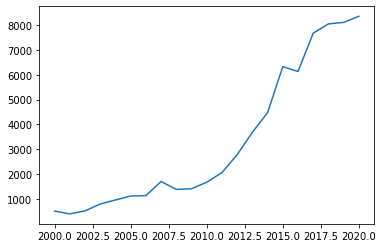

In [14]:
edges_subgraph=[]
nodes_subgraph=[]
avg_degree_subgraph=[]
for year in range(2000,2021):
    edges_subgraph.append(locals()["SG_"+str(year)].number_of_edges())
    nodes_subgraph.append(locals()["SG_"+str(year)].number_of_nodes())
    #avg_degree_subgraph.append(2*locals()["SG_"+str(year)].number_of_edges()/(locals()["SG_"+str(year)].number_of_nodes()+1))
    
plt.plot(range(2000,2021), edges_subgraph)

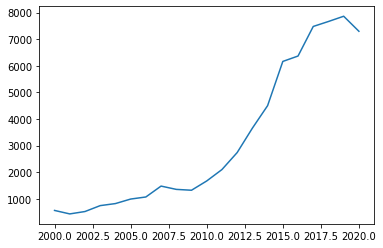

In [15]:
plt.plot(range(2000,2021), nodes_subgraph)

### Projections

There is no algorithm that projects multigraphs. The following one tries to figure out a possible solution (indeed it has some drawbacks and some arbitrary technicalities)

Indeed, two investors that have invested in the same company, in the same year TWICE are connected by a SINGLE arc (we are using years as granular basis)

In [9]:
def project_multi(B, nodes, name):
    G=nx.MultiGraph(name=name)
    count=0
    for node in nodes:
        ego=nx.ego_graph(B, node)
        ndx=list(ego.nodes())
        ndx.remove(node)
        for year in range(2000,2021): # bad trick to link depending on year
            subndx=[x for x in ndx if [y for y in list(ego.edges(data=True)) if y[0]==x or y[1]==x][0][2]['date']==year]
            for couple in itertools.combinations(subndx, 2):
                if G.has_edge(couple[0], couple[1]):
                    continue
                G.add_edge(couple[0], couple[1], anno = year)
        count+=1
        if count%1000==0:
            print(count, end=' ')
    return G

In [10]:
##IMPO: BIDBID è IL NETWORK TRA STARTUPS!!
orgorg=project_multi(B, bid_nodes, name='bid-bid')

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 

In [ ]:
print(nx.info(bidbid))

In [11]:
bidbid=project_multi(B, org_nodes, name='org-org')

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 

In [ ]:
print(nx.info(orgorg))

In [ ]:
# Save projections :-)
nx.readwrite.write_gpickle(bidbid, 'bidbid.gpickle')
nx.readwrite.write_gpickle(orgorg, 'orgorg.gpickle')

## Network characterisation

### Descriptive statistics

#### Degree

In [42]:
B_degree=dict(B.degree())

In [47]:
sorted_degree=dict(sorted(B_degree.items(), key=lambda item: item[1], reverse=True))

Degree distribution

<AxesSubplot:>

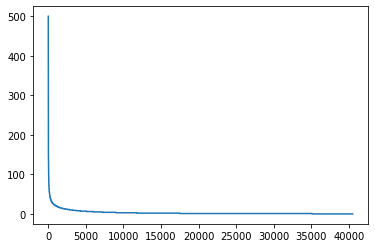

In [53]:
pd.Series(sorted_degree.values()).plot()

Zoom-in on the first 200 nodes

<AxesSubplot:>

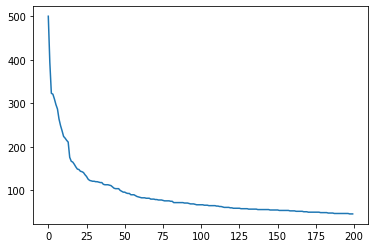

In [63]:
pd.Series(sorted_degree.values())[:200].plot()

In [65]:
print(nx.info(B))

Name: org-bid
Type: MultiGraph
Number of nodes: 40509
Number of edges: 70861
Average degree:   3.4985


In [98]:
nodes['Node']=='EASME - EU Executive Agency for SMEs'

,Node,Country,bipartite,id,lat,long,Coo
0,Meddy,United Arab Emirates,1,0,25.075010,55.188761,"(25.0750095, 55.18876088183319)"
1,Lemonaid Health,United States,1,1,37.779026,-122.419906,"(37.7790262, -122.4199061)"
2,Prellis Biologics,United States,1,2,37.779026,-122.419906,"(37.7790262, -122.4199061)"
3,Memed,Brazil,1,3,-23.550651,-46.633382,"(-23.5506507, -46.6333824)"
4,1859,United States,1,4,32.717420,-117.162773,"(32.7174202, -117.1627728)"
...,...,...,...,...,...,...,...
40505,ZWC Partners,Hong Kong,0,40505,22.279328,114.162813,"(22.2793278, 114.1628131)"
40506,Zygote Ventures,United States,0,40506,37.973535,-122.531087,"(37.9735346, -122.5310874)"
40507,Zynik Capital Corp.,Canada,0,40507,49.260872,-123.113953,"(49.2608724, -123.1139529)"
40508,ZZ Capital,China,0,40508,39.906217,116.391276,"(39.906217, 116.3912757)"


In [104]:
# Do not repeat it

# nodes['degrees']=np.nan

In [87]:
# I collegamenti interni ci sono perché hai più di un collegamento nel multigrafo
# Con questa funzione ottieni tutti i collegamenti e tutti i round per anno di ogni singolo nodo di investitori


# for i in B.adjacency():
#     print(i)

In [108]:
#adding the degree in the df - doesn't need repeating
degrees=B.degree()
for i in tqdm(range(len(nodes))):
    try: 
        nodes.iloc[i,7]=degrees[i]
    except:
        nodes.iloc[i,7]=np.nan

  0%|          | 0/40510 [00:00<?, ?it/s]

In [109]:
nodes['Node']==''

,Node,Country,bipartite,id,lat,long,Coo,degrees
0,Meddy,United Arab Emirates,1,0,25.075010,55.188761,"(25.0750095, 55.18876088183319)",6.0
1,Lemonaid Health,United States,1,1,37.779026,-122.419906,"(37.7790262, -122.4199061)",18.0
2,Prellis Biologics,United States,1,2,37.779026,-122.419906,"(37.7790262, -122.4199061)",15.0
3,Memed,Brazil,1,3,-23.550651,-46.633382,"(-23.5506507, -46.6333824)",10.0
4,1859,United States,1,4,32.717420,-117.162773,"(32.7174202, -117.1627728)",0.0
...,...,...,...,...,...,...,...,...
40505,ZWC Partners,Hong Kong,0,40505,22.279328,114.162813,"(22.2793278, 114.1628131)",2.0
40506,Zygote Ventures,United States,0,40506,37.973535,-122.531087,"(37.9735346, -122.5310874)",2.0
40507,Zynik Capital Corp.,Canada,0,40507,49.260872,-123.113953,"(49.2608724, -123.1139529)",1.0
40508,ZZ Capital,China,0,40508,39.906217,116.391276,"(39.906217, 116.3912757)",1.0


In [195]:
# # In sospeso per ora, bisogna capire se un grafico è fattibile o meno

# pos = nx.spring_layout(B)
# nx.draw(B, pos, node_color=range(24), cmap=plt.cm.Blues)
# plt.show()

### Connected components

In [196]:
conn_components=nx.number_connected_components(B)
conn_components

7554

<AxesSubplot:>

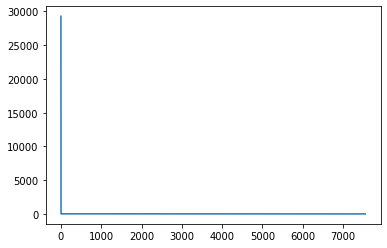

In [235]:
#connected components
pd.Series([len(c) for c in sorted(nx.connected_components(B), key=len, reverse=True)]).plot()

In [237]:
# Length of connected components

# [len(c) for c in sorted(nx.connected_components(B), key=len, reverse=True)]

In [151]:
dictionary={}
count=0
for component in nx.connected_components(B):
    dictionary[count]=(component,len(component))
    count+=1

In [187]:
for node in tqdm(range(len(nodes))):
    dictionary2={}
    for component in range(len(dictionary)):
        if node in dictionary[component][0]:
            dictionary2[component]=dictionary[component][1]
    try:
        nodes.iloc[node,8]=[dictionary2]
    except:
        nodes.iloc[node,8]=np.nan

  0%|          | 0/40510 [00:00<?, ?it/s]

Node                   AILIS Breast Cancer Prediction Technology
Country                                                   Poland
bipartite                                                      1
id                                                         13433
lat                                                    50.061947
long                                                   19.936856
Coo                                     (50.0619474, 19.9368564)
degrees                                                      4.0
Connected component                                   {1: 29284}
Name: 13433, dtype: object

### Measures of centrality

In [194]:
deg_centrality=nx.degree_centrality(B)

In [214]:
insieme=set()
count=0
for i in B.edges():
    if i in insieme:
        count+=1
    else:
        insieme.add(i)

In [217]:
#Percentuale di edges che sono ripetuti

count/70861

0.22679612198529517

Questo significa che, se abbiamo 22% di edges ripetuti, semplificare il network senza considerare la ripetizione ci toglie abbastanza informazioni. Dovremmo andare a controllare i nodi

<b>Voterank</b>

In [242]:
votes=nx.voterank(B)

In [293]:
# for count in range(len(nodes)):
#     nodes.iloc[count,10]=[nodes.iloc[count]['Connected component'].keys()]
#     nodes.iloc[count,11]=[nodes.iloc[count]['Connected component'].values()]

In [310]:
# for i in range(len(votes)):
#     nodes.iloc[votes[i],8]=i+1

<b>Degree centrality</b>

In [ ]:
deg_centrality=nx.degree_centrality(B)

In [331]:
for i in deg_centrality:
    nodes.iloc[i,11]=deg_centrality[i]

<b>Eigenvector centrality</b>

Per eigenvector centrality quello che facciamo è rendere il network da multigraph a single graph weighted. I weights li computiamo sulla base del totale dei soldi che sono stati raccolti da un lato e sulla base del totale dei soldi raccolti diviso il numero di investitori dall'altro. Computiamo poi eigenvector centrality con una moving window di quattro anni e poi sull'intero network. 
Facciamo la stessa cosa con il network di investitori. 

## Structural holes

Constraint means that 

In [348]:
constraint=nx.constraint(B)

In [350]:
# constraint

## Interpretation of the network

In [333]:
nodes.sort_values(by='Vote_rank')

,Node,Country,bipartite,id,lat,long,Coo,degrees,Vote_rank,Conn_component_nr,Conn_component_dim,degree_centrality
27333,EASME - EU Executive Agency for SMEs,Belgium,0,27333,50.846557,4.351697,"(50.8465573, 4.351697)",500.0,1.0,(1),(29284),0.012343
33854,New Enterprise Associates,United States,0,33854,37.451967,-122.177993,"(37.4519671, -122.1779927)",394.0,2.0,(1),(29284),0.009726
40145,Y Combinator,United States,0,40145,37.389389,-122.083210,"(37.3893889, -122.0832101)",323.0,3.0,(1),(29284),0.007974
32720,MassChallenge,United States,0,32720,42.360253,-71.058291,"(42.3602534, -71.0582912)",321.0,4.0,(1),(29284),0.007924
37362,SOSV,United States,0,37362,40.349274,-74.659296,"(40.3492744, -74.6592958)",310.0,5.0,(1),(29284),0.007653
...,...,...,...,...,...,...,...,...,...,...,...,...
40505,ZWC Partners,Hong Kong,0,40505,22.279328,114.162813,"(22.2793278, 114.1628131)",2.0,NaN,(1),(29284),0.000049
40506,Zygote Ventures,United States,0,40506,37.973535,-122.531087,"(37.9735346, -122.5310874)",2.0,NaN,(1),(29284),0.000049
40507,Zynik Capital Corp.,Canada,0,40507,49.260872,-123.113953,"(49.2608724, -123.1139529)",1.0,NaN,(1),(29284),0.000025
40508,ZZ Capital,China,0,40508,39.906217,116.391276,"(39.906217, 116.3912757)",1.0,NaN,(1),(29284),0.000025


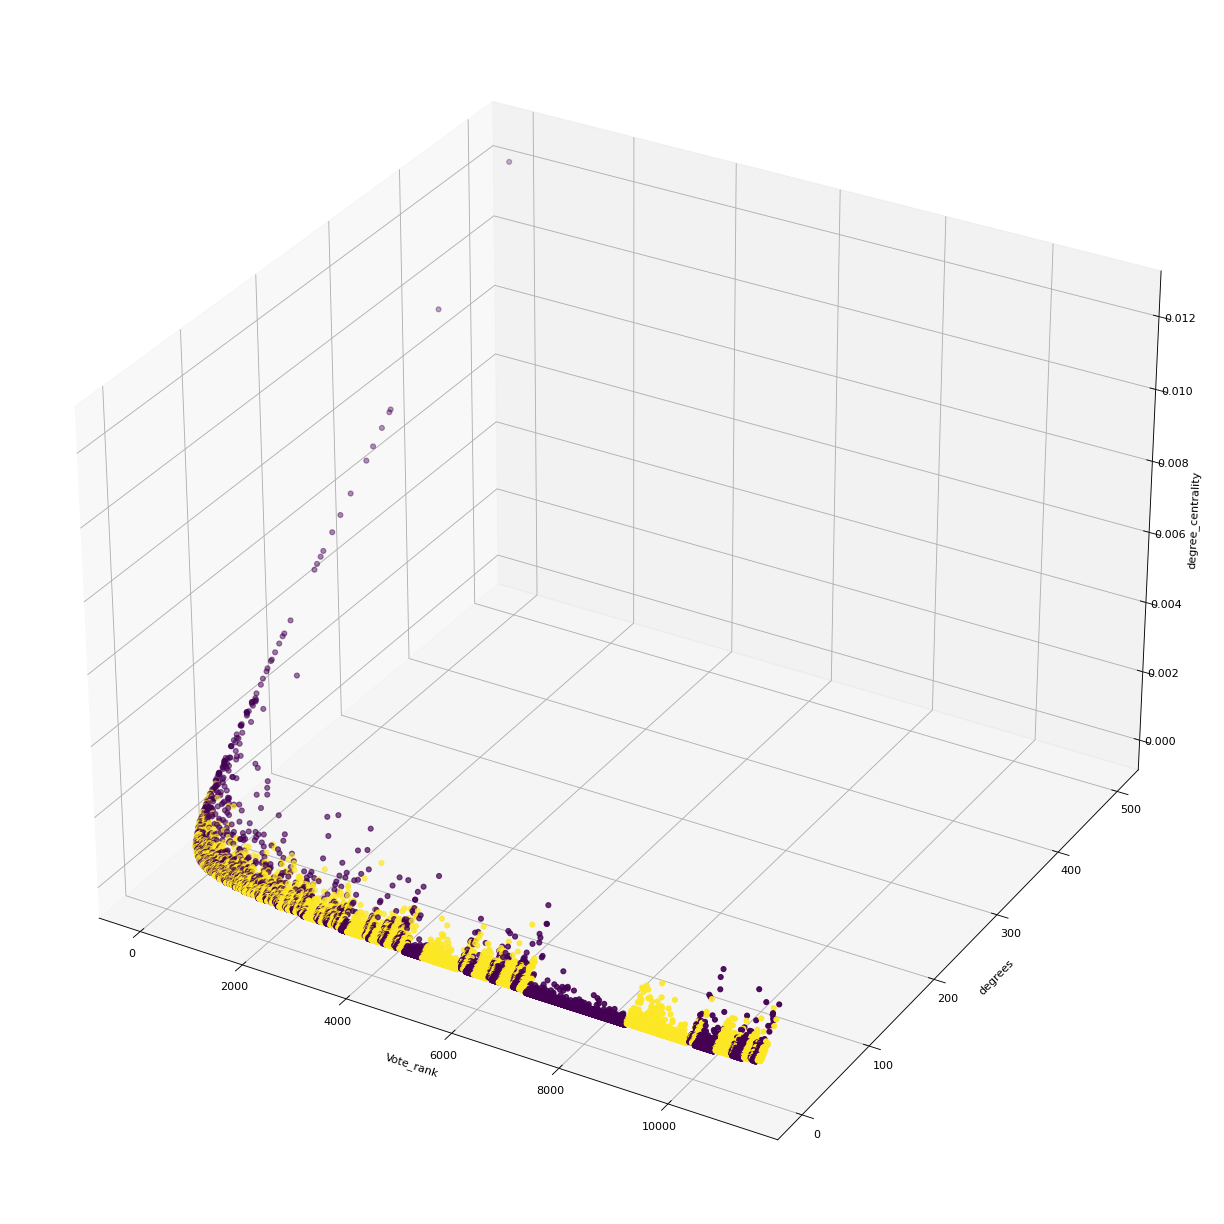

In [339]:
threedee = plt.figure(figsize=(20, 20), dpi=80).gca(projection='3d')
threedee.scatter(nodes['Vote_rank'], nodes['degrees'], nodes['degree_centrality'],c=nodes['bipartite'])
threedee.set_xlabel('Vote_rank')
threedee.set_ylabel('degrees')
threedee.set_zlabel('degree_centrality')
plt.show()

In [342]:
# #Modify to get the mapping with the continents
# threedee = plt.figure(figsize=(20, 20), dpi=80).gca(projection='3d')
# threedee.scatter(nodes['Vote_rank'], nodes['degrees'], nodes['degree_centrality'],c=nodes['Country'])
# threedee.set_xlabel('Vote_rank')
# threedee.set_ylabel('degrees')
# threedee.set_zlabel('degree_centrality')
# plt.show()

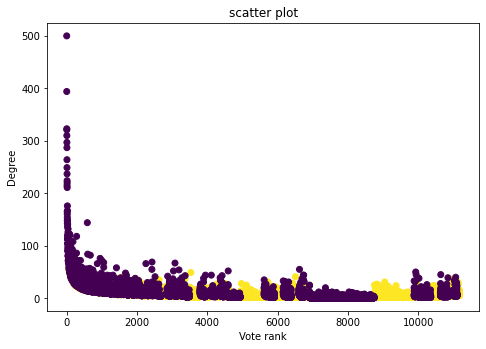

In [347]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(nodes['Vote_rank'], nodes['degrees'], c=nodes['bipartite'])
ax.set_xlabel('Vote rank')
ax.set_ylabel('Degree')
ax.set_title('scatter plot')
plt.show()

### Link prediction

In [93]:
#to apply jaccard we need normalh graph. We consider a combination of B and bidbid
##Bsingle
Bsingle = nx.Graph()
for u,v,data in B.edges(data=True):
    d = data['date'] if 'date' in data else np.nan
    m = data['m_raised'] if 'm_raised' in data else np.nan
    if Bsingle.has_edge(u,v):
        Bsingle[u][v]['date'] = B[u][v][0]['date']
        if np.isnan(m):
            Bsingle[u][v]['m_raised'] =B[u][v][0]['m_raised']
        if np.isnan(m) == False and np.isnan(B[u][v][0]['m_raised']):
            Bsingle[u][v]['m_raised'] = m
        if np.isnan(m) == False and np.isnan(B[u][v][0]['m_raised'])==False:
            Bsingle[u][v]['m_raised'] += m
    else:
        Bsingle.add_edge(u, v, date=d)
        Bsingle.add_edge(u, v, m_raised = m)
    

In [ ]:
for u,v,data in orgorg.edges(data=True):
    print(data['anno'])

In [94]:
##orgorgs
orgorgsingle = nx.Graph()
for u,v,data in orgorg.edges(data=True):
    if orgorgsingle.has_edge(u,v) == False:
        orgorgsingle.add_edge(u, v, anno = data['anno'])

In [95]:
##grafo unito
F = nx.compose(Bsingle,orgorgsingle)

In [18]:
nx.info(B)

'Name: org-bid\nType: MultiGraph\nNumber of nodes: 40509\nNumber of edges: 70861\nAverage degree:   3.4985'

#### Jaccard 

In [96]:
jacques = []
for u,v,data in tqdm(F.edges(data=True)):
    j = nx.jaccard_coefficient(F, [(u,v)])
    for u,v,p in j:
        jacques.append(p)
    


In [ ]:
max(jacques)

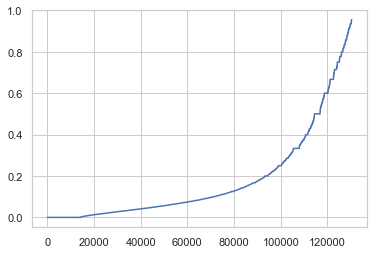

In [97]:
plt.plot(sorted(jacques))

#### Adamic/Adar

In [98]:
adam = []
for u,v,data in tqdm(F.edges(data=True)):
    j = nx.adamic_adar_index(F, [(u,v)])
    for u,v,p in j:
        adam.append(p)
    


In [ ]:
plt.plot(sorted(adam))

In [92]:
stats.pearsonr(jacques,adam)

ValueError: x and y must have the same length.

#### enorme trial

In [99]:
##vedo un po' quanto ci metto per subset di 1000
import random
jacqgrande = []
oosn = list(orgorgsingle.nodes)
random.seed(10)
oosns = random.sample(oosn, 1000)
for u in tqdm(oosns):
    for v in oosns:
        if u!=v:
            j = nx.jaccard_coefficient(orgorgsingle, [(u,v)])
            for u,v,p in j:
                jacqgrande.append(p)
    


In [ ]:
plt.plot(sorted(jacqgrande))

#### Modello logistico

In [101]:
ootrial = nx.Graph([(u,v,d) for u,v,d in orgorgsingle.edges(data=True) if d['anno'] in range(2000,2019)])
ootest = nx.Graph([(u,v,d) for u,v,d in orgorgsingle.edges(data=True) if d['anno'] in range (2000,2020)])

In [62]:
import random
col1 = []
col2 = []
jacqtrial = []
adamtrial = []
saltontrial =[]
legame = []
legame2 = []
ootrn = list(ootrial.nodes)
random.seed(10)
ootrns = random.sample(ootrn, 2000)
for u in tqdm(ootrns):
    for v in ootrns:
        if u!=v:
            j = nx.jaccard_coefficient(ootrial, [(u,v)])
            for u,v,p in j:
                if u>v:
                    col1.append(u)
                    col2.append(v)
                    jacqtrial.append(p)
                    legame.append(int(ootrial.has_edge(u,v)))
                    legame2.append(int(ootest.has_edge(u,v)))
                    saltontrial.append(salton_index(ootrial, [(u,v)]))
                    aa = nx.adamic_adar_index(ootrial, [(u,v)])
                    for u,v,p in aa:
                        adamtrial.append(p)

In [102]:
dfpred = pd.DataFrame({'col1': col1, 'col2': col2, 'jacc': jacqtrial, 'legame': legame, 'legame2':legame2, 'adam':adamtrial, 
                       'salton':saltontrial, 'intercetta':1})

In [104]:
len(dfpred)

1999000

In [105]:
dfpred2 = dfpred[dfpred['legame']== 0]

In [106]:
dfpred2[dfpred2['legame2']==1]

,col1,col2,jacc,legame,legame2,adam,salton,intercetta
114585,39036,38505,0.000000,0,1,0.000000,0.000000,1
114827,39036,31360,0.000000,0,1,0.000000,0.000000,1
114873,39036,23523,0.011050,0,1,0.410513,0.021858,1
115059,39036,31124,0.008929,0,1,0.193834,0.022751,1
115061,39036,37467,0.087591,0,1,2.543387,0.165710,1
...,...,...,...,...,...,...,...,...
1991621,36750,24940,0.000000,0,1,0.000000,0.000000,1
1992045,36750,34332,0.000000,0,1,0.000000,0.000000,1
1992363,36750,27281,0.000000,0,1,0.000000,0.000000,1
1992795,36750,25600,0.016949,0,1,0.191757,0.041667,1


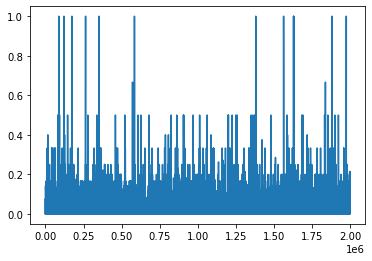

In [66]:
plt.plot(list(dfpred2['jacc']))

In [107]:
##tools necessari per logisticregression

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [111]:
dfpred['legame2'].value_counts()

0    1997318
1       1682
Name: legame2, dtype: int64

In [113]:
dfpred2.groupby('legame2').mean()

,col1,col2,jacc,legame,adam,salton,intercetta
legame2,,,,,,,
0,34697.298102,28668.019659,0.000628,0.0,0.005673,0.001466,1.0
1,35431.258503,29142.605442,0.018608,0.0,0.320420,0.037138,1.0


In [114]:
dfpred3 = dfpred2[['jacc','legame2','adam','intercetta','salton']]
dfpred3.head()

,jacc,legame2,adam,intercetta,salton
0,0.0,0,0.0,1,0.0
1,0.0,0,0.0,1,0.0
2,0.0,0,0.0,1,0.0
3,0.0,0,0.0,1,0.0
4,0.0,0,0.0,1,0.0


In [115]:
##oversampling
X = dfpred3.loc[:, dfpred3.columns != 'legame2']
y = dfpred3.loc[:, dfpred3.columns == 'legame2']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['legame2'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['legame2']==0]))
print("Number of subscription",len(os_data_y[os_data_y['legame2']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['legame2']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['legame2']==1])/len(os_data_X))


length of oversampled data is  2796230
Number of no subscription in oversampled data 1398115
Number of subscription 1398115
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [117]:
os_data_X

,jacc,adam,intercetta,salton
0,0.000000,0.000000,1,0.000000
1,0.000000,0.000000,1,0.000000
2,0.000000,0.000000,1,0.000000
3,0.000000,0.000000,1,0.000000
4,0.000000,0.000000,1,0.000000
...,...,...,...,...
2796225,0.022249,0.819083,1,0.046265
2796226,0.013780,0.639050,1,0.029032
2796227,0.000000,0.000000,1,0.000000
2796228,0.012485,0.516267,1,0.032970


In [118]:
logit_model=sm.Logit(os_data_y,os_data_X)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.573556
         Iterations 10
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.173       
Dependent Variable: legame2          AIC:              3207599.6614
Date:               2021-08-15 00:02 BIC:              3207651.0366
No. Observations:   2796230          Log-Likelihood:   -1.6038e+06 
Df Model:           3                LL-Null:          -1.9382e+06 
Df Residuals:       2796226          LLR p-value:      0.0000      
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     10.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
jacc           -19.2979   0.7020  -27.4917 0.0000 -20.6738 -17.9221
adam            10.1439   0.0387  262.06

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y.values.ravel(), test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [86]:
X_train

,jacc,adam,intercetta,salton
1907249,0.0,0.0,1,0.0
2264725,0.0,0.0,1,0.0
1197852,0.0,0.0,1,0.0
340907,0.0,0.0,1,0.0
2027577,0.0,0.0,1,0.0
...,...,...,...,...
2249467,0.0,0.0,1,0.0
963395,0.0,0.0,1,0.0
2215104,0.0,0.0,1,0.0
1484405,0.0,0.0,1,0.0


In [88]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[412912   6940]
 [262327 156690]]


In [ ]:
stats.pearsonr(list(dfpred3['legame2']),list(dfpred3['jacc']))

### Modello con aggiustamento rare events
per info check King G and Zeng L (2001). “Logistic Regression in Rare Events Data.” Political Analysis, 9 (2), pp. 137-163.

In [20]:
##creo indice non presente in network x
def salton_index(G, coppia):
    u = coppia[0][0]
    v = coppia[0][1]
    neigh1 = [n for n in G[u]]
    neigh2 = [n for n in G[v]]
    numerator = len(list(set(neigh1) & set(neigh2)))
    deg1 = G.degree[u]
    deg2 = G.degree[v]
    denominator = math.sqrt(deg1*deg2)
    salton = numerator/denominator
    return salton

In [24]:
##creo jacc modificato
def jacc_index(G, coppia):
    u = coppia[0][0]
    v = coppia[0][1]
    neigh1 = [n for n in G[u]]
    neigh2 = [n for n in G[v]]
    numerator = len(list(set(neigh1) & set(neigh2)))
    denominator = len(list(set(neigh1 + neigh2)))
    jacc = numerator/denominator
    return jacc

In [26]:
jacc_index(F,[(22557,0)])

0.7142857142857143

In [32]:
##Prima prendo quelli collegati nel network con 2020 compreso con valori di interesse
import random
col1 = []
col2 = []
existing = []
linktrial = []
linktest = []
jacq = []
adam = []
salton = []
for u,v,data in tqdm(ootest.edges(data=True)):
    if u>v:
        col1.append(u)
        col2.append(v)
        linktrial.append(int(ootrial.has_edge(u,v)))
        linktest.append(int(ootest.has_edge(u,v)))
        existing.append(int(ootrial.has_node(u)&ootrial.has_node(v)))
        if int(ootrial.has_node(u)&ootrial.has_node(v)):
            j = nx.jaccard_coefficient(ootrial, [(u,v)])
            for u,v,p in j:
                jacq.append(p)
            aa = nx.adamic_adar_index(ootrial, [(u,v)])
            for u,v,p in aa:
                adam.append(p)
            salton.append(salton_index(ootrial, [(u,v)]))
        else:
            jacq.append(0)
            adam.append(0)
            salton.append(0)
dflogis = pd.DataFrame({'col1':col1, 'col2':col2, 'existing':existing, 'linktrial':linktrial, 'linktest':linktest,
                       'jacq' : jacq, 'adam':adam, 'salton' : salton})
numbers = len(dflogis[(dflogis['existing']==1) & (dflogis['linktest']== 1) & (dflogis['linktrial']== 0) ])
list_of_candidates = list((ootrial.nodes))
list_degree = [val for (node, val) in ootrial.degree()]
list_degree_p = []
for number in list_degree:
    list_degree_p.append(number/sum(list_degree))
random.seed(10)
draw1 = choice(list_of_candidates, numbers*15,
              p= list_degree_p, replace=True)
p2 = []
for number in list_degree:
    p2.append(1/len(list_degree))
random.seed(11)
draw2 = choice(list_of_candidates, numbers*15,
              p= list_degree_p, replace=True)
count = 0

for i in tqdm(range(len(draw1))):
    while count < numbers*10:
        if ootrial.has_edge(draw1[i], draw2[i])==False and ootest.has_edge(draw1[i], draw2[i]) == False:
            col1.append(draw1[i])
            col2.append(draw2[i])
            existing.append(1)
            linktrial.append(0)
            linktest.append(0)
            j = nx.jaccard_coefficient(ootrial, [(draw1[i],draw2[i])])
            for u,v,p in j:
                jacq.append(p)
            aa = nx.adamic_adar_index(ootrial, [(draw1[i],draw2[i])])
            for u,v,p in aa:
                adam.append(p)
            salton.append(salton_index(ootrial, [(draw1[i],draw2[i])]))
            count+=1
                          
dflogis = pd.DataFrame({'col1':col1, 'col2':col2, 'existing':existing, 'linktrial':linktrial, 'linktest':linktest,
                        'jacq':jacq, 'adam':adam, 'salton':salton})


In [34]:
len(dflogis[(dflogis['existing']==1) & (dflogis['linktest']== 0) & (dflogis['linktrial']== 0) ])


21410

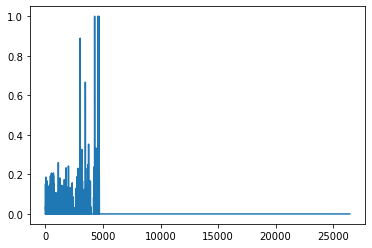

In [35]:
plt.plot(list(dflogis[dflogis['linktrial']==0]['jacq']))

In [36]:
nx.info(ootrial)

'Name: \nType: Graph\nNumber of nodes: 10758\nNumber of edges: 49601\nAverage degree:   9.2212'

In [ ]:
jacqito = list(dflogis[(dflogis['existing']!=0) & (dflogis['linktrial']== 1)]['jacq'])

In [ ]:
dfristretto = dflogis[(dflogis['existing']==1) & (dflogis['linktrial']== 0)]

In [ ]:
len(set(dfristretto['col1']))

In [ ]:
plt.plot(sorted(jacqito))

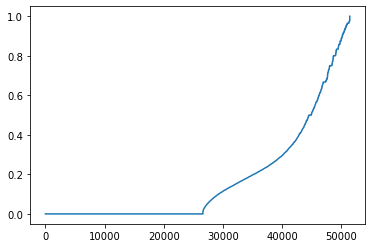

In [37]:
plt.plot(sorted(salton))

In [38]:
stats.pearsonr(jacq,salton)

(0.969012573633117, 0.0)

In [39]:
dflogis2 = (dflogis[(dflogis['existing']==1) & (dflogis['linktrial']== 0) ])
dflogis2['intercetta']=1

<ipython-input-39-05059706a07f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dflogis2['intercetta']=1


In [42]:
dflogis2.groupby('linktest').sum()

,col1,col2,existing,linktrial,jacq,adam,salton,intercetta
linktest,,,,,,,,
0,608622070,704538870,21410,0,0.000000,0.00000,0.000000,21410
1,74099268,61115408,2141,0,45.802672,1280.58529,97.570698,2141


In [559]:
draw2[i]

27540

In [43]:
y = dflogis2['linktest']
X = dflogis2[['adam','salton','intercetta']]

In [46]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.202533
         Iterations: 35
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.335    
Dependent Variable:     linktest            AIC:                 9545.7006
Date:                   2021-08-14 15:26    BIC:                 9569.9013
No. Observations:       23551               Log-Likelihood:      -4769.9  
Df Model:               2                   LL-Null:             -7174.5  
Df Residuals:           23548               LLR p-value:         0.0000   
Converged:              0.0000              Scale:               1.0000   
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
            Coef.     Std.Err.     z     P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------
adam       126.7902 122735.8986   0.0010 0.9992  -240431.1508  2

C:\Users\Marco\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [49]:
y

10       1
12       1
16       1
17       1
37       1
        ..
51425    0
51426    0
51427    0
51428    0
51429    0
Name: linktest, Length: 23551, dtype: int64

### Summary statistics

In [ ]:
print(nx.info(B))

In [ ]:
bipartite.density(B, bid_nodes)

### Dynamic community discovery

In [ ]:
tc = TemporalClustering()
for year in range(2000,2021):
    coms = algorithms.bimlpa(locals()["SG_"+str(year)])  # here any CDlib algorithm can be applied -- Ask Rossetti for ambiguity
    tc.add_clustering(coms, year)

In [ ]:
from cdlib import TemporalClustering

In [ ]:
tc2 = TemporalClustering()
for year in range(2000,2021):
    coms = algorithms.louvain(locals()["SG_"+str(year)])  # Louvain
    tc2.add_clustering(coms, year)

In [ ]:
size = [len(x) for x in tc2.get_clustering_at(2017).communities]
mod = evaluation.avg_distance(SG_2017, tc2.get_clustering_at(2017), summary=False)

In [ ]:
plt.plot(size, mod, '.')
plt.xlabel('size')
plt.ylabel('avg_distance')
plt.show()

In [ ]:
common_n = lambda x, y:  len(set(x) & set(y))
match_list=tc2.community_matching(method=common_n)

In [ ]:
[(x[0], len(tc2.get_community(x[0])), x[1], len(tc2.get_community(x[1])), x[2]) for x in match_list if x[2]>100]

## Link prediction

## Functional data analysis

### Data preparation

In [ ]:
data=Pallottola[['Organisation', 'id_x', 'USDraised_cpi', 'Date']]

In [ ]:
data.Date=data.Date.dt.year

In [ ]:
data=data[data.Date>=2000]
data=data[data.Date<2021]

In [ ]:
data=data.groupby(['id_x','Organisation','Date']).sum().reset_index()

In [ ]:
data=data.pivot('Date','id_x','USDraised_cpi')

In [ ]:
data

In [ ]:
data.to_csv('to_functionalise.csv')

### Functional clustering

### Function - on - scalar and function - on - function regressions